In [96]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import random

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [97]:
# import the data
df = pd.read_csv("collected data9.6.2019/merged_data.csv", index_col=0)

In [98]:
df.shape

(37839, 260)

In [99]:
# calculate total minutes of play time for each player by reversing formula spm * minutes = score
df['minutes'] = df['score']/df['spm']
df['kpm'] = df['kills']/df['minutes']

In [100]:
# through the previous EDA we recall that it's best to eliminate top 1% and bottom 1% of players based on spm
upper = np.percentile(df.spm, 99)
lower = np.percentile(df.spm, 1)

df = df[(df['spm'] >= lower) & (df['spm'] <= upper)]

In [101]:
# Create arrays for features and target variable
y = df['spm'].values
X = df['kills'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1,1)
X = X.reshape(-1,1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (37081,)
Dimensions of X before reshaping: (37081,)
Dimensions of y after reshaping: (37081, 1)
Dimensions of X after reshaping: (37081, 1)


### Linear Regression - Single Independent Variable for testing

In [106]:
import numpy as np
np.corrcoef(df['spm'],df['kills'])

array([[1.        , 0.27770404],
       [0.27770404, 1.        ]])

In [102]:
# Create the regressor: reg
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)

# Fit the model to the data
reg.fit(X, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2 
print(reg.score(X, y))

0.077119534528448


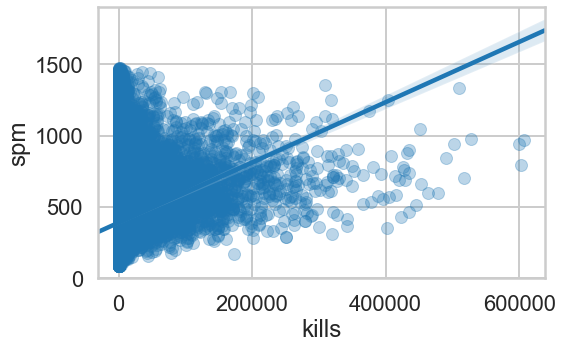

In [94]:
# Plot regression line
_ = plt.figure(figsize=(8,5))
_ = sns.regplot('kills', 'spm', data=df, fit_reg = True, scatter_kws={'alpha':0.3})

**Comment**: The R^2 and plot could signify that there are multiple factors that contribute to a high score per minute(spm). Kills alone does not explain why a player is able to obtain a high score per minute(spm).


### Create an Evaulaute Function for Hyperparameter Testing

In [107]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

### Feature Cleanup

In [108]:
# remove columns with duplicate values along with rankings, id, unlocks, medals
x_cols = df.drop(['player_id','time','ladder_rank','score','skill',
                  'battle_rank','scores.rankScore','extra.spm','extra.gspm',
                  'extra.medals','extra.ribbonsUnique','extra.medalsUnique',
                  'extra.ribbons','extra.ribpr','scores.unlock'],axis=1)
x_cols.shape

(37081, 247)

In [109]:
X = x_cols.drop(['spm'],axis = 1)
y = x_cols.spm

In [110]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

### Train/Test Split

In [13]:
# Split data into training and testing data
from sklearn.model_selection import train_test_split
random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(27810, 246)
(27810,)
(9271, 246)
(9271,)


### Random Forest

In [15]:
#Import randomforest regressor model
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

In [16]:
%%time
regr.fit(X_train, y_train)

Wall time: 1min 18s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [17]:
# make predictions on the testing set
y_pred = np.array(regr.predict(X_test))

In [18]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

114.72883901379886


In [19]:
# calculate MAE using scikit-learn
print(metrics.mean_absolute_error(y_test, y_pred))

78.62505505612644


In [20]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.7791975898812761
0.7772269265685305


In [21]:
base_accuracy = evaluate(regr, X_test, y_test)
print(base_accuracy)

Model Performance
Average Error: 78.6251 degrees.
Accuracy = 77.53%.
77.52751305899588


### Hyperparameter Tuning - Random Forest

In [23]:
# Grid Search with Cross Validation
# Look at parameters
regr.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [24]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [25]:
# notes this may take a long time to finish running
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 23.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [26]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [27]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 51.4744 degrees.
Accuracy = 86.32%.


In [28]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 10.81%.


In [116]:
regr = RandomForestRegressor(bootstrap = True, max_depth=10, random_state=0, 
                             n_estimators=200, min_samples_leaf = 2, min_samples_split = 2)

In [117]:
%%time
regr.fit(X_train, y_train)

Wall time: 6min 48s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [118]:
# make predictions on the testing set
y_pred = np.array(regr.predict(X_test))

In [36]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

81.3561415747356


In [37]:
# calculate MAE using scikit-learn
print(metrics.mean_absolute_error(y_test, y_pred))

51.432851118141464


In [38]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.8889702661662613
0.8879793248854464


### Support Vector Machine

In [67]:
#Import support vector machine for regression model
from sklearn.svm import SVR
svmod = SVR(gamma = 'scale', C = 1.0, epsilon = 0.1)

In [68]:
%%time
svmod.fit(X_test, y_test)

Wall time: 24.9 s


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [69]:
# make predictions on the testing set
y_pred = np.array(svmod.predict(X_test))

In [70]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

222.07144584843473


In [71]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

152.48153417758687


In [72]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.17273613973917157
0.1653528030332918


### Hyperparameter Tuning - SVM

In [73]:
# Grid Search with Cross Validation
# Look at parameters
svmod.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [76]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.1],
    'gamma': ['scale']
}

# Create a based model
svr = SVR()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [77]:
# notes this may take a long time to finish running
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 10.0min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 18.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'epsilon': [0.1],
                         'gamma': ['scale']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [78]:
grid_search.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}

In [79]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
base_accuracy = evaluate(svmod, X_test, y_test)
print(base_accuracy)

Model Performance
Average Error: 131.2202 degrees.
Accuracy = 66.05%.
Model Performance
Average Error: 152.4815 degrees.
Accuracy = 58.87%.
58.86602320351347


In [80]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 12.20%.


In [81]:
svmod = SVR(gamma = 'scale', C = 10, epsilon = 0.1)

In [82]:
%%time
svmod.fit(X_train, y_train)

Wall time: 4min 23s


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [83]:
# make predictions on the testing set
y_pred = np.array(svmod.predict(X_test))

In [84]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

200.89798011112077


In [85]:
# calculate MAE using scikit-learn
print(metrics.mean_absolute_error(y_test, y_pred))

131.2202110814529


In [86]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.3229671328663485
0.3169246090004819


### Lasso Regression

In [48]:
#Import linear model and load lasso
from sklearn import linear_model
lsr = linear_model.Lasso(alpha= 4, tol = 1)

In [49]:
%%time
lsr.fit(X_test, y_test)

Wall time: 74.8 ms


Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=1, warm_start=False)

In [50]:
# make predictions on the testing set
y_pred = np.array(lsr.predict(X_test))

In [51]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

124.07923256912454


In [52]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

80.06656670494704


In [53]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.7417402006316467
0.7394352298140792


### Hyperparameter Tuning - Lasso

In [156]:
# Grid Search with Cross Validation
# Look at parameters
lsr.get_params()

{'alpha': 4,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 1,
 'warm_start': False}

In [167]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha': [5, 4, 3, 2, 1],
    'tol': [1]
}

# Create a based model
lsr_base = linear_model.Lasso()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lsr_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [168]:
# notes this may take a long time to finish running
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [5, 4, 3, 2, 1], 'tol': [1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [169]:
grid_search.best_params_

{'alpha': 3, 'tol': 1}

In [172]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
base_accuracy = evaluate(lsr, X_test, y_test)
print(base_accuracy)

Model Performance
Average Error: 402.6419 degrees.
Accuracy = 48.18%.
Model Performance
Average Error: 80.0666 degrees.
Accuracy = 76.56%.
76.55737636705908


In [161]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -37.06%.


In [173]:
# test accuracy on training data
grid_accuracy = evaluate(best_grid, X_train, y_train)
print(grid_accuracy)

Model Performance
Average Error: 74.8517 degrees.
Accuracy = 78.45%.
78.45464223039201


**Comment**: Based on the training data, the model has indeed improved by 2% in accuracy, however, using the testing data, we can see the model is thrown off and drops in accuracy by 37%. It's best to keep alpha = 4 as the parameter for lasso.

### Ridge Regression

In [55]:
#Import linear model and load ridge
from sklearn.linear_model import Ridge

In [56]:
rg = Ridge(alpha=0.5)

In [57]:
%%time
rg.fit(X_test, y_test)

Wall time: 205 ms


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
# make predictions on the testing set
y_pred = np.array(rg.predict(X_test))

In [59]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

111.82514466950511


In [60]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

72.69792575740283


In [61]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.790232815419692
0.7883606415849587


### Hyperparameter Tuning - Ridge

In [258]:
# Grid Search with Cross Validation
# Look at parameters
rg.get_params()

{'alpha': 0.5,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [265]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha': [0.005, 0.05, 0.5, 5, 50, 500, 5000]
}

# Create a based model
rg_base = Ridge()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rg_base, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [266]:
# notes this may take a long time to finish running
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.005, 0.05, 0.5, 5, 50, 500, 5000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [267]:
grid_search.best_params_

{'alpha': 0.005}

In [268]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
base_accuracy = evaluate(rg, X_test, y_test)
print(base_accuracy)

Model Performance
Average Error: 199.8905 degrees.
Accuracy = 67.61%.
Model Performance
Average Error: 72.6979 degrees.
Accuracy = 78.37%.
78.3747556684148


In [269]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -13.74%.


In [270]:
# test accuracy on training data
grid_accuracy = evaluate(best_grid, X_train, y_train)
print(grid_accuracy)

Model Performance
Average Error: 68.1395 degrees.
Accuracy = 79.89%.
79.8911665576546


**comment**: The ridge regression seems to suffer the same issue with lasso, where the model improves ny 1% using the training data, but drops in accuracy based on the test data. Hence it's best to keep alpha = 0.5 as the parameter for ridge for now.

### Table - Default Models

|Original  | Random Forest | Support Vector Machine | Lasso Regression | Ridge Regression |
|----------|---------------|------------------------|------------------|------------------|
| RMSE     | 108.73        | 222.05                 | 124.07           | 111.82           |
| MAE      | 75.67         | 152.48                 | 80.06            | 72.69            |
| R^2 adj. | 0.799         | 0.165                  | 0.739            | 0.788            |

### Table - Hyperparameter Adjusted Models

|Hyper Adj.| Random Forest | Support Vector Machine | Lasso Regression | Ridge Regression |
|----------|---------------|------------------------|------------------|------------------|
| RMSE     | 81.35         | 200.89                 | N/A              | N/A              |
| MAE      | 51.43         | 131.22                 | N/A              | N/A              |
| R^2 adj. | 0.887         | 0.316                  | N/A              | N/A              |

### Reading feature importances for Random Forest

In [113]:
list_of_tuples = list(zip(X.columns, regr.feature_importances_))
df = pd.DataFrame(list_of_tuples, columns = ['Features', 'Importance']) 

In [114]:
df.sort_values(by='Importance', ascending=False).head(10)

,Features,Importance
29,kits.assault.spm,0.678236
58,scores.award,0.068048
36,kits.engineer.spm,0.067571
44,kits.support.spm,0.016708
164,ASSAULT RIFLE_stat.score,0.014352
28,kits.assault.score,0.013097
218,Main Battle Tanks_extra.spm,0.011637
183,SIDEARM_extra.spm,0.008457
17,extra.weaTimeP,0.008365
70,timePlayed,0.008048


**comments:** based on the feature importance generated through the random forest regressor, we can see that features 
such as assault kit, engineering kit, support kit, battle tank spm, assault rifle score contributes greatly to the
prediction of an spm score. Though whether the feature positively or negatively affected the final spm is unknown.

### Reading feature coefficience for Lasso Regression

In [111]:
list_of_tuples = list(zip(X.columns, lsr.coef_))
df2 = pd.DataFrame(list_of_tuples, columns = ['Features', 'coefficient']) 

In [112]:
df2.sort_values(by='coefficient', ascending=False).head(15)

,Features,coefficient
6,extra.kdr,9.233383
3,extra.accuracy,4.096844
20,extra.wlr,3.251054
17,extra.weaTimeP,3.010952
9,extra.sfpm,1.475354
26,killStreakBonus,1.365634
4,extra.assignments,1.308751
136,GRENADE_extra.accuracy,0.460505
160,ASSAULT RIFLE_extra.spm,0.450496
148,DMR_extra.sfpm,0.339577


### Reading feature coefficience for Ridge Regression

In [70]:
list_of_tuples = list(zip(X.columns, rg.coef_))
df3 = pd.DataFrame(list_of_tuples, columns = ['Features', 'coefficient']) 

In [71]:
df3.sort_values(by='coefficient', ascending=False).head(15)

,Features,coefficient
16,extra.weaKpm,25.032769
6,extra.kdr,20.248546
20,extra.wlr,13.073811
17,extra.weaTimeP,5.344921
3,extra.accuracy,3.885223
12,extra.vehTimeP,3.668227
9,extra.sfpm,1.113352
160,ASSAULT RIFLE_extra.spm,0.805036
136,GRENADE_extra.accuracy,0.545930
122,BATTLE PICKUP_stat.kills,0.525416
